In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from hog_extractor import extract_hog_features
from lbp_extractor import extract_lbp_features
from cnn_extractor import load_pretrained_model, extract_cnn_features
import pickle

Importing Dataset


In [2]:
def load_dataset(dataset_path):
    images = []
    labels = []
    # Each subdirectory is a class corresponding to a person
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Only consider JPG images
            for file in os.listdir(person_path):
                if file.lower().endswith(".jpg"):
                    img_path = os.path.join(person_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Resize image to a fixed size
                        img = cv2.resize(img, (128, 128))  # Resize to 128x128
                        if len(img.shape) == 2:  # If grayscale, convert to 3 channels
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

                        images.append(img)
                        labels.append(person)
    return images, labels


dataset_path = 'VGG2_Dataset'
images, labels = load_dataset(dataset_path)
print(f"Loaded {len(images)} images for {len(set(labels))} persons.")


Loaded 16936 images for 50 persons.


In [6]:
print("Number of images:",len(images))
print("Number of labels:", len(labels))
print("size of images:", images[0].shape)

Number of images: 16936
Number of labels: 16936
size of images: (128, 128, 3)


Face Detection and Cropping (For Avoiding Background Noise)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image in BGR format.
    - cascade_path: Name of the Haar cascade XML file (default is for frontal face detection).
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces (tweak scaleFactor, minNeighbors, minSize as needed)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, faces

    # Option: Choose the largest detected face
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    return face_resized, faces

def load_dataset_with_face_detection(dataset_path):
    """
    Loads images from a dataset folder with one subfolder per person, applies face detection and cropping,
    and returns lists of cropped face images and corresponding labels.
    
    Parameters:
    - dataset_path: Path to the main dataset folder.
    
    Returns:
    - cropped_images: List of cropped face images.
    - labels: List of labels corresponding to each image.
    """
    cropped_images = []
    labels = []
    
    # Iterate over each person's folder
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Process only .jpg files
            for file in os.listdir(person_path):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(person_path, file)
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    # Apply face detection and crop the face
                    face, _ = detect_and_crop_face(image)
                    if face is not None:
                        cropped_images.append(face)
                        labels.append(person)
                    else:
                        print(f"No face detected in image: {img_path}")
    
    return cropped_images, labels

def display_images(images, labels, num_samples=5):
    """
    Displays a few sample images with their labels in a Jupyter Notebook using Matplotlib.
    
    Parameters:
    - images: List of images in BGR format.
    - labels: Corresponding labels.
    - num_samples: Number of samples to display.
    """
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = images[i]
        label = labels[i]
        # Convert from BGR to RGB for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Example usage in a Jupyter Notebook:
dataset_path = 'VGG2_Dataset'  # Update with your dataset location
images, labels = load_dataset_with_face_detection(dataset_path)
print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons.")

# Display a few sample images inline
display_images(images, labels, num_samples=5)


In [2]:
# Path to pickle file

pickle_file = 'cropped_faces.pkl'

# Check if pickle file exists
if os.path.exists(pickle_file):
    # Load data from pickle file
    with open(pickle_file, 'rb') as f:
        images, labels = pickle.load(f)
    print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons from pickle file.")
else:
    # Load dataset with face detection and save to pickle file
    images, labels = load_dataset_with_face_detection(dataset_path)
    with open(pickle_file, 'wb') as f:
        pickle.dump((images, labels), f)
    print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons and saved to pickle file.")

Loaded 13550 cropped face images for 50 persons from pickle file.


In [10]:
print(images[0].shape)
print(images[0])
print(images[1])
print(labels[0])
print(labels[1])

(128, 128, 3)
[[[ 10  29  79]
  [ 16  32  79]
  [ 26  38  81]
  ...
  [225 223 226]
  [241 240 242]
  [245 245 245]]

 [[ 10  30  81]
  [ 24  40  87]
  [ 19  29  73]
  ...
  [213 212 215]
  [227 226 228]
  [229 229 229]]

 [[ 24  40  82]
  [ 20  33  78]
  [ 16  26  73]
  ...
  [205 205 212]
  [217 215 218]
  [224 219 219]]

 ...

 [[ 22  26  55]
  [ 20  22  46]
  [ 16  15  35]
  ...
  [242 242 242]
  [241 241 241]
  [244 242 242]]

 [[  7  12  40]
  [ 20  23  47]
  [ 23  22  41]
  ...
  [239 239 239]
  [240 240 240]
  [247 245 245]]

 [[ 14  16  39]
  [ 22  23  45]
  [ 16  17  37]
  ...
  [235 234 238]
  [242 241 245]
  [248 245 247]]]
[[[ 25  49 149]
  [ 13  36 137]
  [ 21  43 145]
  ...
  [120 169 159]
  [113 163 149]
  [117 167 149]]

 [[ 28  50 150]
  [  2  25 125]
  [ 22  45 146]
  ...
  [121 172 165]
  [112 165 152]
  [109 162 145]]

 [[ 20  39 137]
  [  9  33 128]
  [ 30  55 149]
  ...
  [127 176 175]
  [112 166 156]
  [106 161 143]]

 ...

 [[ 10  29 108]
  [ 22  39 119]
  [ 17

Extracting features from all images

In [5]:
def extract_all_features(images):
    """
    images: NumPy array of shape (n_samples, 128, 128, 3)
    Returns: combined features of shape (n_samples, combined_feature_length)
    """
    all_features = []
    for idx, img in enumerate(images):
        # Extract features from each image
        # pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        bnp_feat = extract_lbp_features(img)
        cnn_feat = extract_cnn_features(img, model, device)
        
        # Concatenate all features into one vector
        # combined = np.concatenate([pixel_feat, hog_feat, bnp_feat])

        
        # Without pixel features
        combined = np.concatenate([cnn_feat,hog_feat, bnp_feat])
        all_features.append(combined)
    return np.array(all_features)

In [ ]:
all_features=extract_all_features(images)
print("Features shape:", all_features.shape)

Features shape: (13550, 8622)


Creating Dataframe 

In [11]:
import pandas as pd

df = pd.DataFrame(all_features)

# Generate column names for features
df.columns = [f'feature_{i}' for i in range(all_features.shape[1])]

# Add the labels column
df['label'] = labels  # Ensure 'labels' has the same length as features

# Display the shape to confirm
print("DataFrame shape:", df.shape)

# Show first few rows
print(df.head())


DataFrame shape: (13550, 8623)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.802903   0.290001   0.128858   0.000000   0.238688   0.237688   
1   1.116099   0.469367   0.052496   0.104782   0.184281   0.381988   
2   1.276211   0.209088   0.306192   0.013604   0.324656   0.243034   
3   0.807911   0.954105   0.029814   0.221272   0.053398   0.002023   
4   1.680442   0.082433   0.103465   0.235430   0.131407   0.028644   

   feature_6  feature_7  feature_8  feature_9  ...  feature_8613  \
0   0.132865   0.250270   0.483003   0.347225  ...      0.057983   
1   0.333514   0.204869   0.544707   0.599683  ...      0.051758   
2   0.313175   0.119498   0.833808   0.340460  ...      0.088074   
3   0.216498   0.133190   0.171440   0.491627  ...      0.042786   
4   0.763736   0.256519   0.166368   1.115368  ...      0.031067   

   feature_8614  feature_8615  feature_8616  feature_8617  feature_8618  \
0      0.047729      0.135986      0.299744      0.156860 

OneHotEncoding for labels


In [18]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply One-Hot Encoding
# one_hot_encoder = OneHotEncoder(sparse_output=False) 
# encoded_labels = one_hot_encoder.fit_transform(df[['label']])  # Convert labels to one-hot encoding

# # Convert to DataFrame with proper column names
# label_columns = [f'label_{i}' for i in range(encoded_labels.shape[1])]

# df_encoded = pd.DataFrame(encoded_labels, columns=label_columns)

# # Drop original label column and concatenate encoded labels
# df = df.drop(columns=['label'])
# df = pd.concat([df, df_encoded], axis=1)


In [19]:
# print(df.head())  # Display first few rows

Label Encoding

In [12]:
from sklearn.model_selection import train_test_split

# Features (X) and Labels (y)
# num_classes = len(set(labels))
# X = df.drop(columns=[f"label_{i}" for i in range(num_classes)])  # Feature matrix
# y = df[[f"label_{i}" for i in range(num_classes)]]  # One-hot encoded labels

X=df.drop(columns=['label'])
y=df['label']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y contains names of persons


Applying Standard Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)  # X is your feature matrix

Applying PCA to reduce dimensionality

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust based on variance plot
X_pca = pca.fit_transform(X_normalized)

In [24]:
pca = PCA(n_components=0.95)  # Retains 95% of the variance
X_pca = pca.fit_transform(X_normalized)

print("Number of selected components:", pca.n_components_)


Number of selected components: 2112


Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (10840, 100), Test set size: (2710, 100)


ANN

Epoch [1/50], Loss: 1.6057, Train Accuracy: 58.69%, Validation Accuracy: 51.48%
Epoch [2/50], Loss: 1.1495, Train Accuracy: 69.77%, Validation Accuracy: 59.56%
Epoch [3/50], Loss: 0.9655, Train Accuracy: 73.63%, Validation Accuracy: 62.29%
Epoch [4/50], Loss: 0.8447, Train Accuracy: 76.45%, Validation Accuracy: 64.13%
Epoch [5/50], Loss: 0.7715, Train Accuracy: 78.13%, Validation Accuracy: 64.06%
Epoch [6/50], Loss: 0.7248, Train Accuracy: 79.57%, Validation Accuracy: 64.10%
Epoch [7/50], Loss: 0.6855, Train Accuracy: 80.65%, Validation Accuracy: 63.87%
Epoch [8/50], Loss: 0.6580, Train Accuracy: 81.94%, Validation Accuracy: 64.50%
Epoch [9/50], Loss: 0.6252, Train Accuracy: 83.19%, Validation Accuracy: 64.80%
Epoch [10/50], Loss: 0.5972, Train Accuracy: 83.92%, Validation Accuracy: 64.43%
Epoch [11/50], Loss: 0.5549, Train Accuracy: 84.74%, Validation Accuracy: 64.43%
Epoch [12/50], Loss: 0.5303, Train Accuracy: 85.52%, Validation Accuracy: 64.10%
Epoch [13/50], Loss: 0.4970, Train Ac

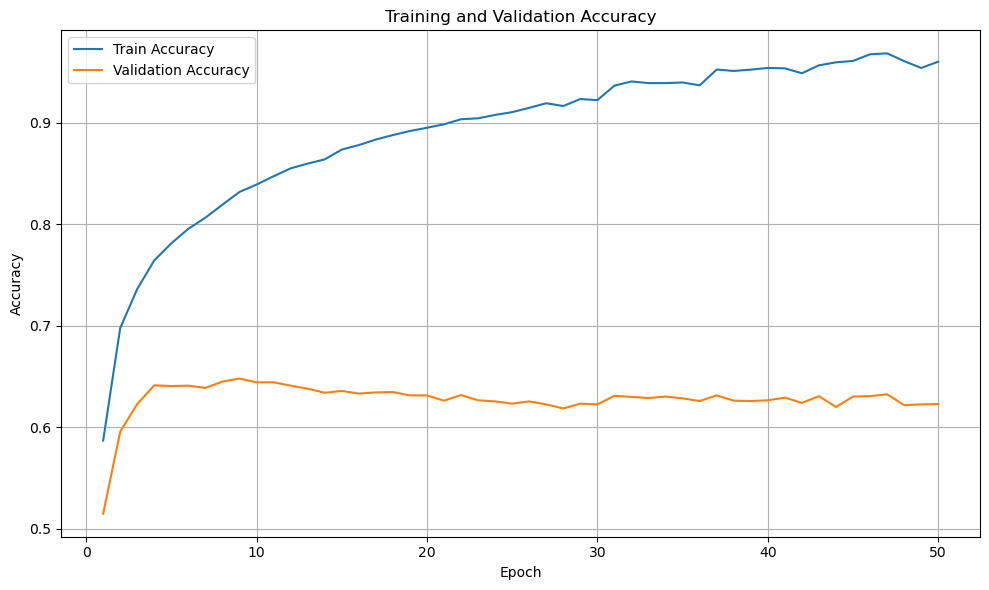

In [36]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

class ANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Model parameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 64  # Number of neurons in hidden layers
num_classes = len(label_encoder.classes_)  # Number of unique labels

# Initialize the model
model = ANNModel(input_size, hidden_size, num_classes)

# ============================
# 3. Train the Model
# ============================
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50  
batch_size = 32

# Track accuracy
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        # Get mini-batch
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate training accuracy
    model.eval()
    with torch.no_grad():
        # Training accuracy
        train_outputs = model(X_train_tensor)
        train_pred_classes = torch.argmax(train_outputs, axis=1)
        train_accuracy = accuracy_score(y_train_tensor.numpy(), train_pred_classes.numpy())
        train_accuracies.append(train_accuracy)

        # Validation accuracy
        val_outputs = model(X_test_tensor)
        val_pred_classes = torch.argmax(val_outputs, axis=1)
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred_classes.numpy())
        val_accuracies.append(val_accuracy)

    # Print loss and accuracies for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# ============================
# 4. Evaluate the Model
# ============================
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1).numpy()
    accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

# ============================
# 5. Save the Model
# ============================
torch.save(model.state_dict(), "ann_model.pth")
print("Model saved as ann_model.pth")

# ============================
# 6. Plot Training and Validation Accuracy
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Till Now best performance is by SVM-75 then Logistic Regression-65 then ANN-62